In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
df = pd.read_csv("marketing_campaign (2).csv", sep='\t')
print("Number of Datapoints:", len(df))
df.head()

Number of Datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [87]:
# To check which columns have null values and types of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [88]:
# Removing null values
df = df.dropna()

In [89]:
# Converting Dt_Customer object to datetime object
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True)

# Checking how long one has been a customer
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)
# Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [90]:
# Creating Customer_For feature
days = []
# Assuming the newest customer date is the date of today
d1 = max(dates)
for i in dates:
    delta = d1 - i
    days.append(delta)
df['Customer_For'] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

In [91]:
# Checking distinct categories for the Martial_Status and Education features
print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [92]:
# Feature Engineering

# Age of customer (newest customer joined in 2014 so using that as the "current" year)
df["Age"] = 2014-df["Year_Birth"]

# Total spending
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

# Separating marital status into "Alone" and "Partner"
df['Living_With'] = df['Marital_Status'].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

# Total children living in the house
df["Children"] = df["Kidhome"]+df["Teenhome"]

# Total people in the house
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner": 2})+ df["Children"]

# If one is a parent
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

# Segmenting education levels in three groups
df["Education"] = df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

# For clarity
df=df.rename(columns={"MntWines": "Wines", "MntFruits":"Fruits", "MntMeatProducts":"Meat", "MntFishProducts":"Fish", "MntSweetProducts":"Sweets", "MntGoldProds":"Gold"})

# Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)

In [93]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,45.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,18.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,37.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,44.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,55.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,121.000000,2525.000000,3.000000,5.000000,1.000000


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

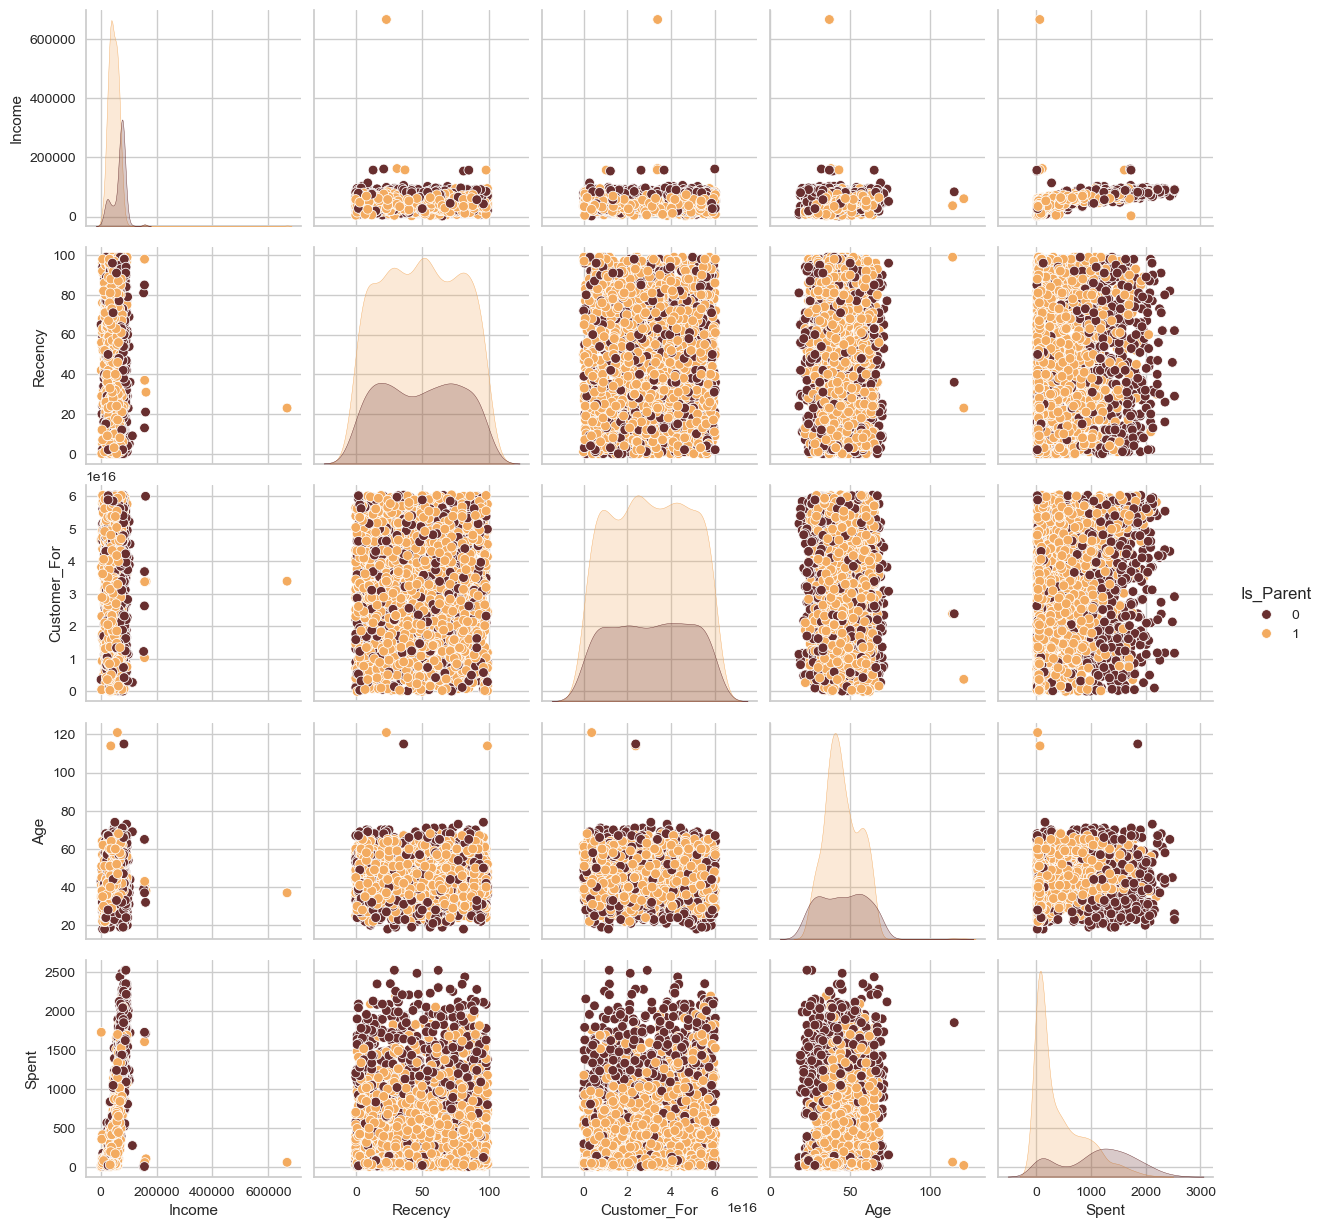

In [94]:
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))

plt.show()

In [95]:
# Noticed that Income has an outlier and max age of 121 doesn't make sense
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]

In [96]:
# Get list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

object_cols

['Education', 'Living_With']

In [97]:
# Transforming categorical data into binary
LE=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)


In [99]:
df2 = df.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
df2 = df2.drop(cols_del, axis=1)
# Scaling data
scaler = StandardScaler()
scaler.fit(df2)
scaled_df = pd.DataFrame(scaler.transform(df2),columns= df2.columns)

In [100]:
scaled_df.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [101]:
# PCA (reducing to only 3 features)
pca = PCA(n_components=3)
pca.fit(scaled_df)
PCA_df = pd.DataFrame(pca.transform(scaled_df), columns=(["col1","col2", "col3"]))
PCA_df.describe()

,col1,col2,col3
count,2.212000e+03,2.212000e+03,2.212000e+03
mean,-2.569775e-17,6.424437e-18,3.854662e-17
std,2.878602e+00,1.709469e+00,1.231685e+00
min,-5.978123e+00,-4.194757e+00,-3.625184e+00
25%,-2.539470e+00,-1.323932e+00,-8.535556e-01
50%,-7.815948e-01,-1.737158e-01,-5.129237e-02
75%,2.386380e+00,1.234923e+00,8.638405e-01
max,7.452915e+00,6.168185e+00,6.746845e+00


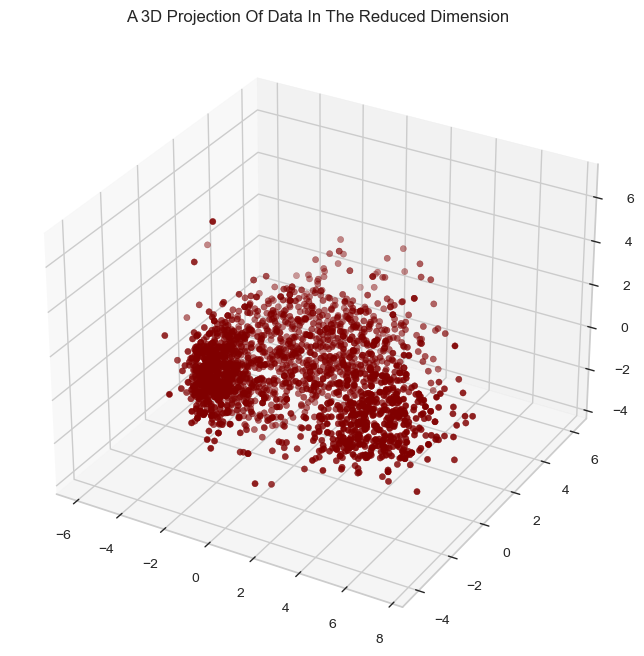

In [102]:
# 3D projection of data in the reduced dimension
x = PCA_df["col1"]
y = PCA_df["col2"]
z = PCA_df["col3"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

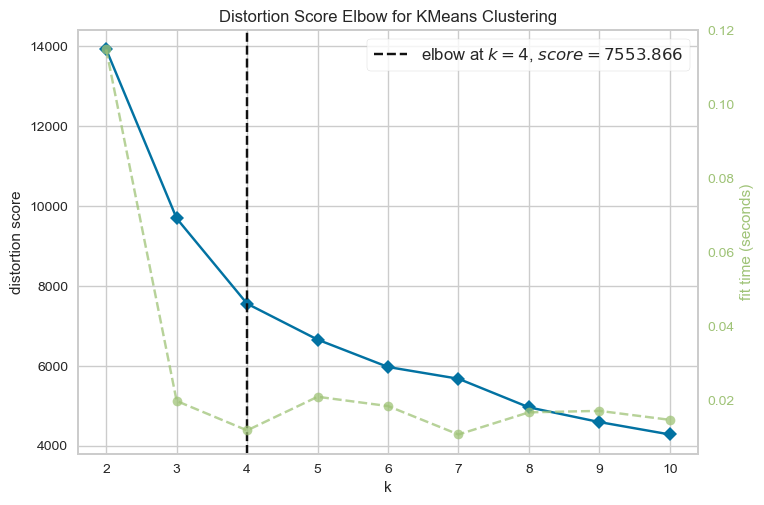

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
# Elbow method to determine clusters k for KNN 
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_df)
Elbow_M.show()

In [104]:
# Agglomerative clustering using 4 clusters from Elbow method above (every data point is its own cluster, eventually all merge, Dendrogram used as a "tree" to visualize length of connections, can cut tree low for many clusters or high for less)
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = yhat_AC
# Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

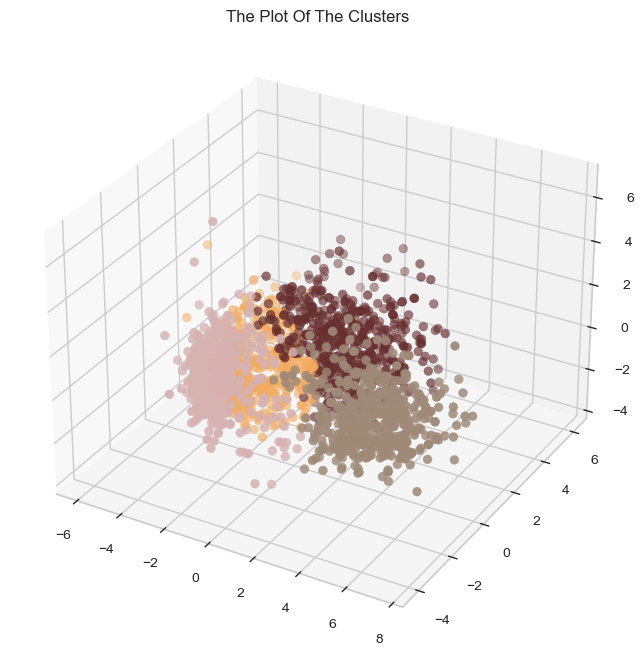

In [105]:
# Visualizing Agglomerative clustering
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"], marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

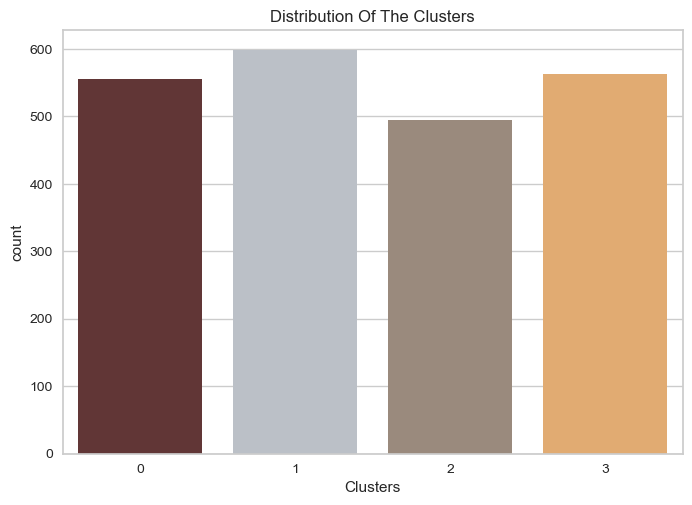

In [106]:
# Plotting to see number of customers per cluster
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

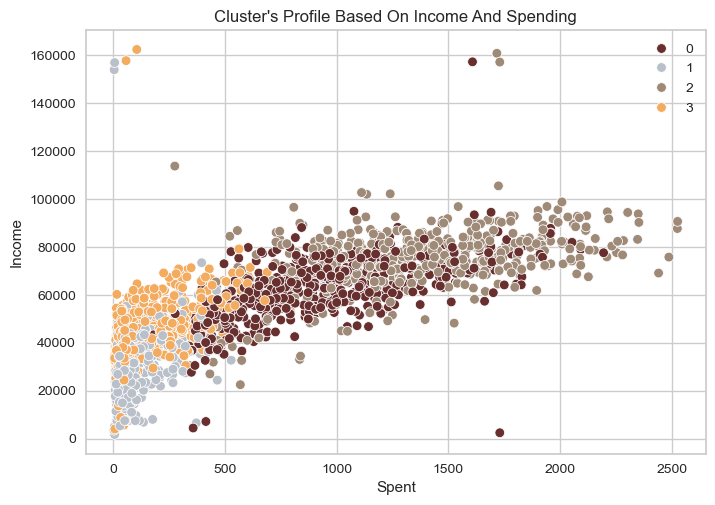

In [107]:
# Plotting to see correlation of Income and Spend in relation to clusters
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

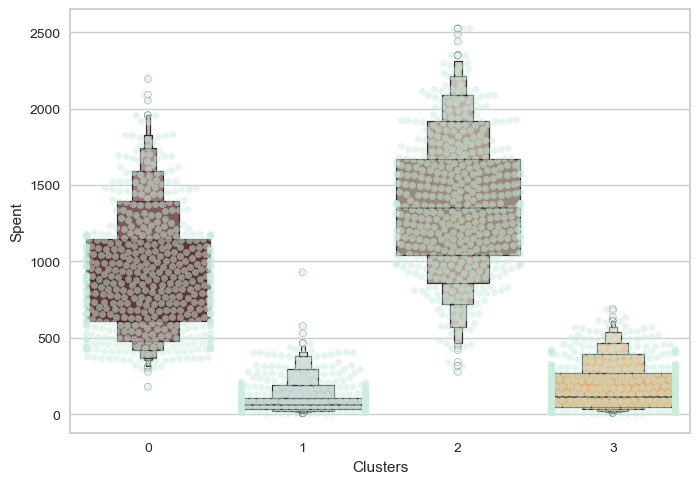

In [108]:
# Box Plots for spend vs clusters
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["Spent"], palette=pal)
plt.show()

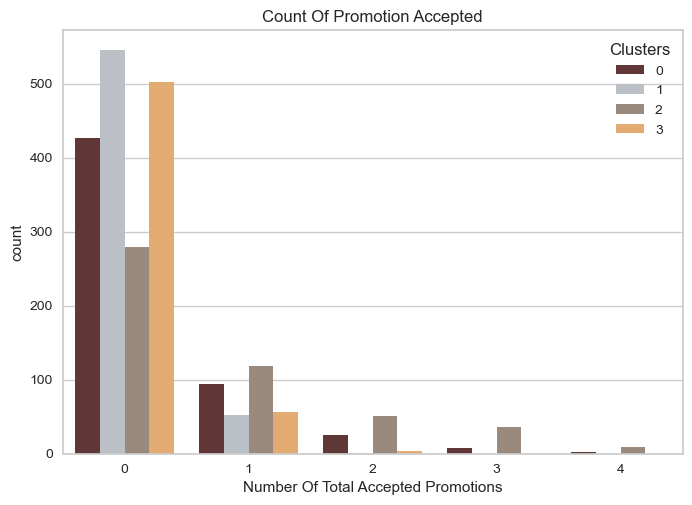

In [109]:
# Count of promotion accepted
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

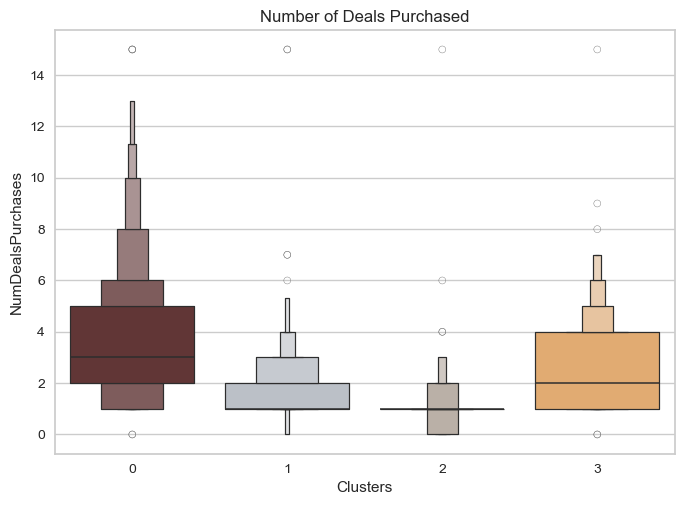

In [110]:
# Plotting number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df["NumDealsPurchases"],x=df["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

<Figure size 800x550 with 0 Axes>

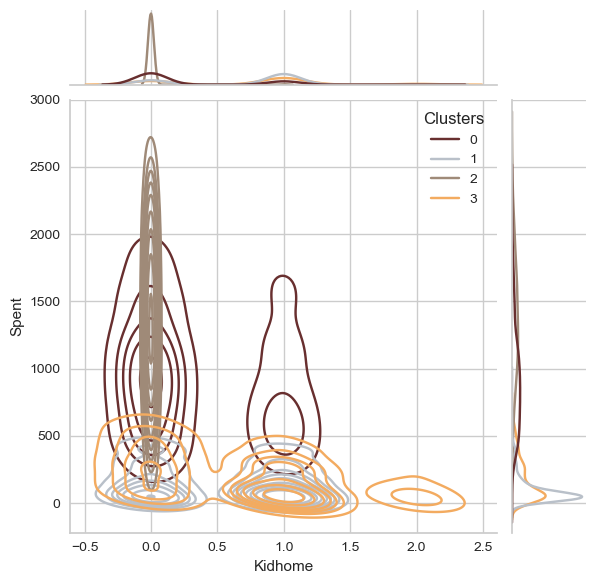

<Figure size 800x550 with 0 Axes>

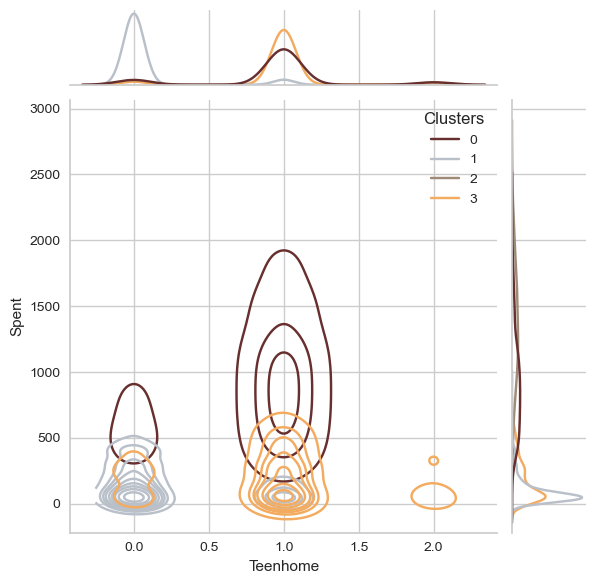

<Figure size 800x550 with 0 Axes>

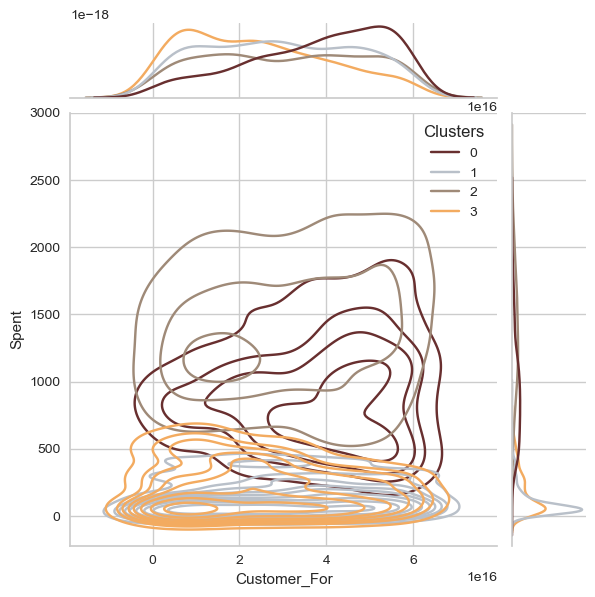

<Figure size 800x550 with 0 Axes>

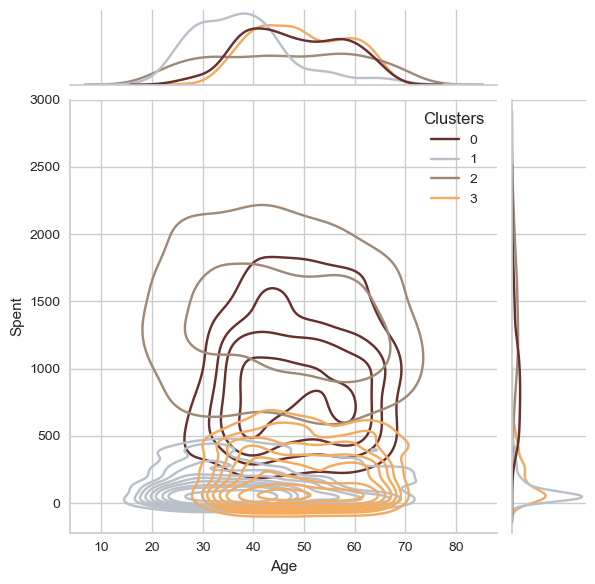

<Figure size 800x550 with 0 Axes>

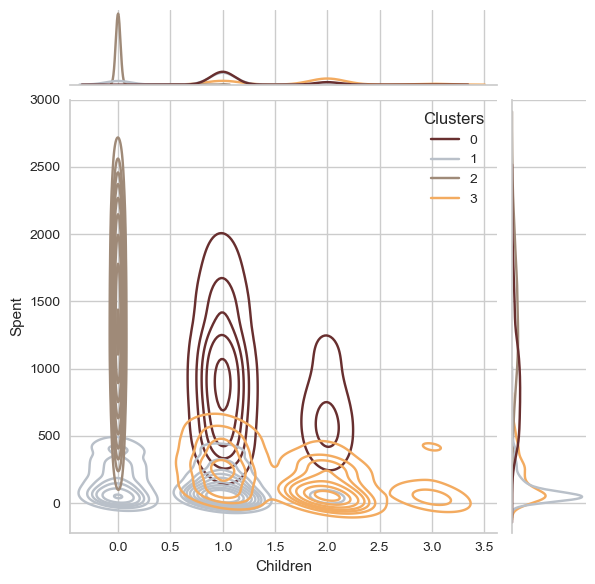

<Figure size 800x550 with 0 Axes>

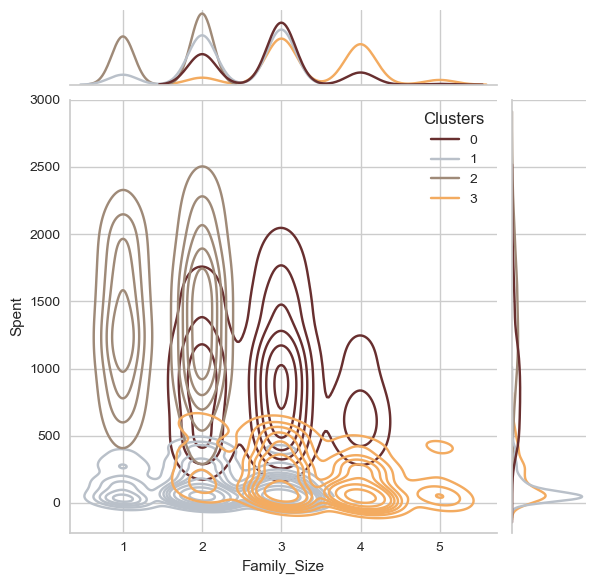

<Figure size 800x550 with 0 Axes>

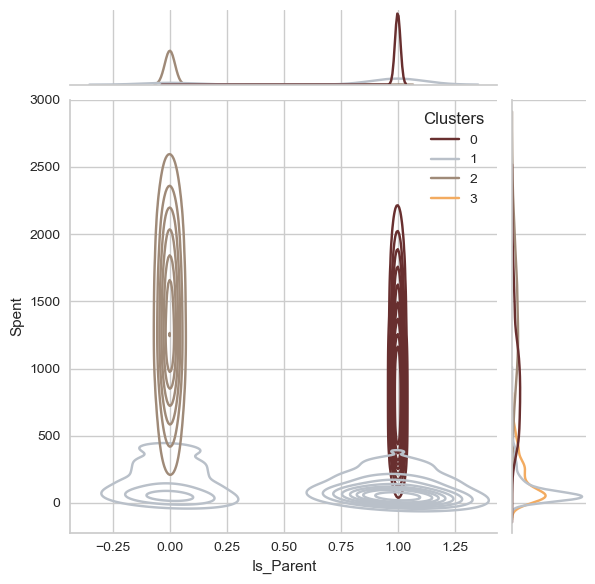

<Figure size 800x550 with 0 Axes>

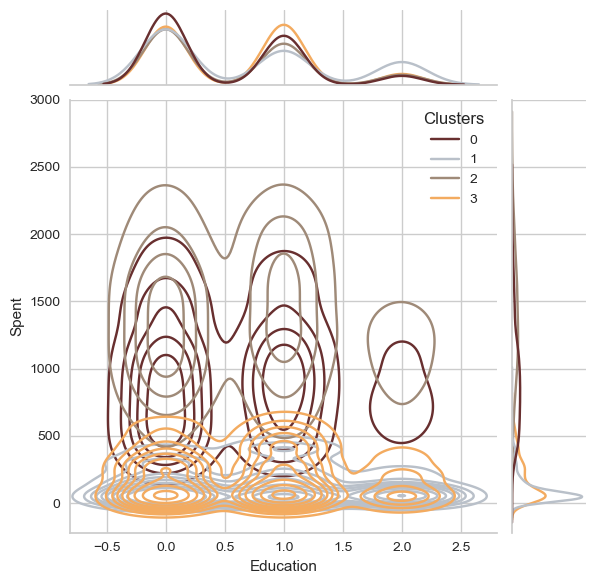

<Figure size 800x550 with 0 Axes>

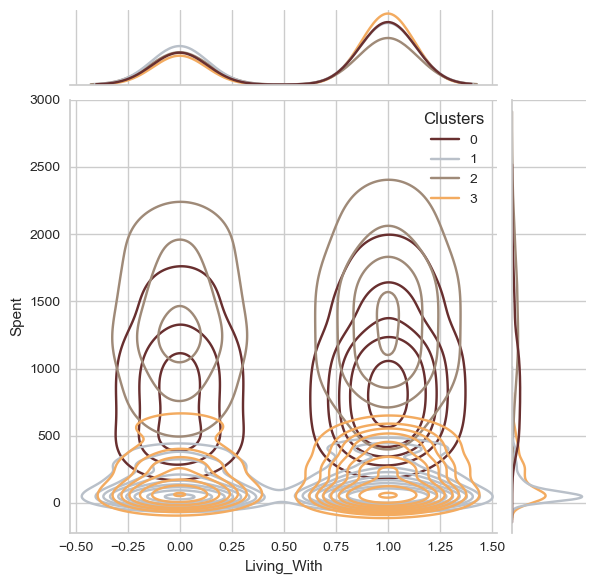

In [111]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Spent"], hue =df["Clusters"], kind="kde", palette=pal)
    plt.show()

In [ ]:
# Analysis of this data analysis is in the README file!